In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
from google.colab import drive
import datetime


In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/Session-Details-Summary-20240119-3.xlsx')

Mounted at /content/drive


In [ ]:
missing_count = df['Port Type'].value_counts().get('Missing', 0)
print(f"Number of missing values in 'Port Type': {missing_count}")

In [5]:
unique_values_time_zone = df['Start Time Zone'].unique()
print(unique_values_time_zone)

['EST' 'CST' 'PST' 'CDT' 'EDT' 'PDT']


In [6]:
# Convert Start and End Date to datetime
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

def convert_to_est(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


# Apply function to Start and End Date
df['Start_Time_EST'] = df.apply(convert_to_est, args=('Start Date', 'Start Time Zone'), axis=1)
df['End_Time_EST'] = df.apply(convert_to_est, args=('End Date', 'End Time Zone'), axis=1)

In [7]:
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = int(parts[2].split()[0])  # Extract seconds and ignore 'AM' or 'PM'
        total_seconds = hours * 3600 + minutes * 60 + seconds
        return total_seconds
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0

In [8]:
df['Total Duration'] = df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds)
df['Charging Time'] = df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds)

In [10]:
count = (df['Charging Time'] > df['Total Duration']).sum()
count

107

In [11]:
df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']

In [12]:
df['Time_Difference'] = df['Total Duration'] - df['Charging Time']


In [13]:
df['Time_Difference'].describe()

count    38624.000000
mean      1426.306804
std       5571.574125
min          0.000000
25%         20.000000
50%         35.000000
75%        117.000000
max      75828.000000
Name: Time_Difference, dtype: float64

In [14]:
count_117 = (df['Time_Difference'] > 117).sum()
count_15_min_more = (df['Time_Difference'] > 900).sum()
count_60_min_more = (df['Time_Difference'] > 3600).sum()

print(f"Number of charging time with more than 117 sec: {count_117}")
print(f"Number of charging time with more than 900 sec- 15min: {count_15_min_more}")
print(f"Number of charging time with more than 3600 sec- 60min: {count_60_min_more}")

Number of charging time with more than 117 sec: 9633
Number of charging time with more than 900 sec- 15min: 4841
Number of charging time with more than 3600 sec- 60min: 3061


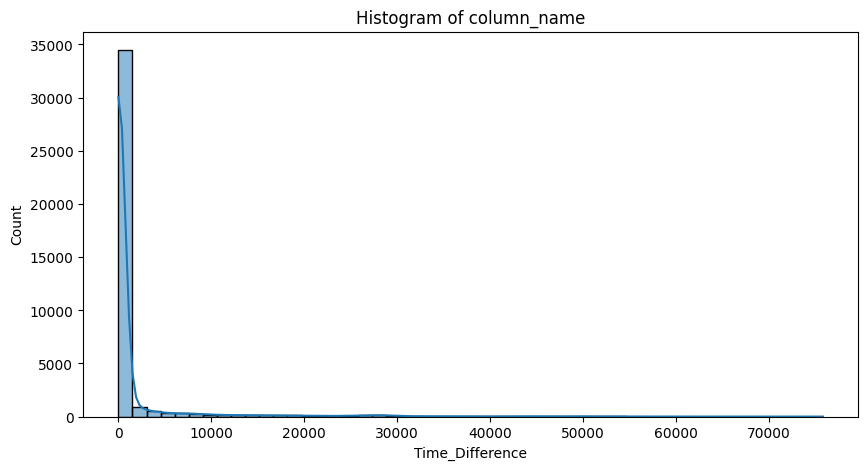

In [ ]:
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['Time_Difference'], bins=50, kde=True)
plt.title('Histogram of column_name')
plt.show()



In [ ]:
charging_time = df['Charging Time']
charging_time_in_hours = charging_time / 3600
charging_time_in_hours.describe()

count    38624.000000
mean         1.503110
std          2.041753
min          0.000000
25%          0.240556
50%          0.744583
75%          1.885972
max         21.887222
Name: Charging Time, dtype: float64

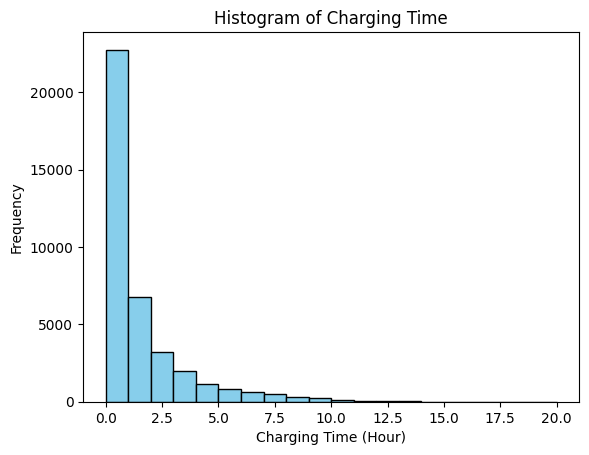

In [ ]:
charging_time = df['Charging Time']

charging_time_in_hours = charging_time / 3600

# Plot histogram
plt.hist(charging_time_in_hours, bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], color='skyblue', edgecolor='black')
plt.title('Histogram of Charging Time')
plt.xlabel('Charging Time (Hour)')
plt.ylabel('Frequency')
plt.show()

In [15]:
unique_values_port_type = df['Port Type'].unique()

port_type_counts = df['Port Type'].value_counts()

print("Unique Values:", unique_values_port_type)

print("Number of charging events")
print(port_type_counts)


Unique Values: ['Level 2' 'DC Fast' nan]
Number of charging events
Level 2    21490
DC Fast    15453
Name: Port Type, dtype: int64


In [16]:
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])

# Create a new column 'Day_of_Week' that represents the day of the week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

In [17]:
# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)

In [ ]:
df['Port Type'] = df['Port Type'].fillna('')

df_L2 = df[df['Port Type'].str.fullmatch('Level 2')]
df_DC = df[df['Port Type'].str.fullmatch('DC Fast')]


In [18]:
df['Station Name'] = df['Station Name'].replace({"7SPC / BR-JC LIBRARY": "7SPC / BR-JC LIBRARY_combined",
                                                         "7SPC / BR - JC LIBRARY": "7SPC / BR-JC LIBRARY_combined"})

In [ ]:
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
df=df.sort_values(by=['Station Name', 'Start_Time_EST'])

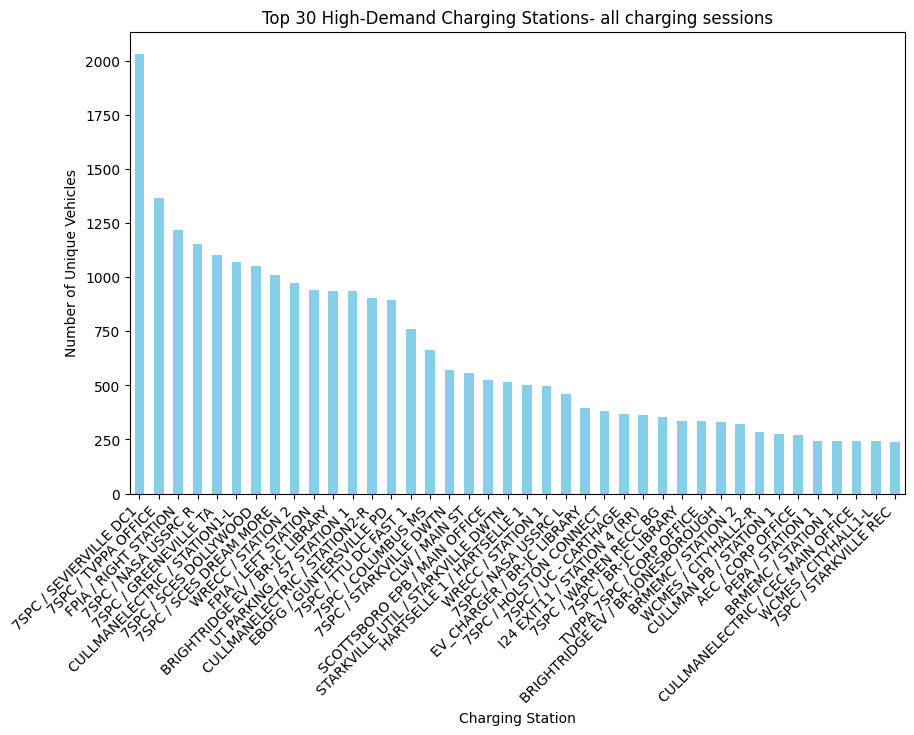

In [ ]:
vehicles_per_station_all = df.groupby('Station Name')['User ID'].count()
top_30_stations_all = vehicles_per_station_all.sort_values(ascending=False).head(40)

plt.figure(figsize=(10, 6))
top_30_stations_all.plot(kind='bar', color='skyblue')
plt.title('Top 30 High-Demand Charging Stations- all charging sessions')
plt.xlabel('Charging Station')
plt.ylabel('Number of Unique Vehicles')
plt.xticks(rotation=45, ha='right')
plt.show()

**Take a look at the highest demand CS**

```
# This is formatted as code
```



**calculate the unique 'User ID' and sum of 'Charging Time'**

In [ ]:
df['Start Date'] = pd.to_datetime(df['Start Date']).dt.date


new_df_unique_users = df.groupby(['Station Name', 'Start Date']).agg({'User ID': pd.Series.nunique, 'Charging Time': 'sum'}).reset_index()


new_df_unique_users.columns = ['Station Name', 'Date', 'Unique User Count', 'Total Charging Time']




**All Users in a day**

In [ ]:

df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST']).dt.date

new_df = df.groupby(['Station Name', 'Start_Time_EST']).agg({'User ID': 'count', 'Charging Time': 'sum', 'Total Duration':'sum', 'Energy (kWh)':'sum',
                                                             'Gasoline Savings (gallons)':'sum','GHG Savings (kg)':'sum', 'Fee':'sum'}).reset_index()


new_df['Charging Time'] = new_df['Charging Time'] / 3600
new_df['Total Duration'] = new_df['Total Duration'] / 3600

new_df.columns = ['Station Name', 'Date', 'User Count', 'Total Charging Time (hours)', 'Total Duration Time (hours)','Total Energy (kWh)', 'Total Gasoline Savings (gallons)',
                  'Total GHG Savings (kg)', 'Total Fee']

new_df['Station Name'] = new_df['Station Name'].replace({"7SPC / BR-JC LIBRARY": "7SPC / BR-JC LIBRARY_combined",
                                                         "7SPC / BR - JC LIBRARY": "7SPC / BR-JC LIBRARY_combined"})

In [ ]:

new_df.to_excel('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/new_dataframe_Day_by_day.xlsx', index=False)


In [ ]:
new_df

,Station Name,Date,User Count,Total Charging Time (hours),Total Duration Time (hours),Total Energy (kWh),Total Gasoline Savings (gallons),Total GHG Savings (kg),Total Fee
0,7SPC / BR-JC LIBRARY_combined,2019-09-26,5,2.383611,4.053889,16.277,2.044,6.836,2.14
1,7SPC / BR-JC LIBRARY_combined,2019-09-27,1,1.384444,1.455556,9.268,1.163,3.892,1.38
2,7SPC / BR-JC LIBRARY_combined,2019-09-28,2,1.338056,1.423056,8.997,1.129,3.778,2.00
3,7SPC / BR-JC LIBRARY_combined,2019-09-30,1,1.060556,1.063611,7.521,0.944,3.159,1.06
4,7SPC / BR-JC LIBRARY_combined,2019-10-02,1,0.225833,0.234722,1.605,0.201,0.674,1.00
...,...,...,...,...,...,...,...,...,...
20804,WRECC / STATION 2,2024-01-13,2,0.284722,0.306944,10.922,1.371,8.257,3.49
20805,WRECC / STATION 2,2024-01-14,3,0.591944,0.612500,43.197,5.421,32.657,13.83
20806,WRECC / STATION 2,2024-01-16,1,0.333889,0.335000,25.070,3.146,18.953,8.02
20807,WRECC / STATION 2,2024-01-17,1,1.095833,1.105833,64.051,8.038,48.422,20.50


In [ ]:
idx = new_df.groupby('Station Name')['Total Charging Time (hours)'].idxmax()

highest_charging_time = new_df.loc[idx, ['Station Name', 'Date', 'Total Charging Time (hours)']]





In [ ]:
highest_charging_time.describe()

,Total Charging Time (hours)
count,152.000000
mean,8.575784
std,7.048024
min,0.000000
25%,2.558542
50%,6.741389
75%,12.958611
max,27.782222


In [ ]:
idx_Energy=new_df.groupby('Station Name')['Total Energy (kWh)'].idxmax()
highest_enrgy_=new_df.loc[idx_Energy,['Station Name', 'Date', 'Total Energy (kWh)']]

### calculate the time difference between the start time of the current session and the end time of the previous one

In [19]:
df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'], utc=True).dt.tz_convert('EST')
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'], utc=True).dt.tz_convert('EST')

df['previous_end_time'] = df.groupby('Station Name')['End_Time_EST'].shift(1)

first_rows_mask = df['Station Name'] != df['Station Name'].shift(1)
df.loc[first_rows_mask, 'previous_end_time'] = df['Start_Time_EST']

df['time_difference_session'] = df['Start_Time_EST'] - df['previous_end_time']

print(df[['Start_Time_EST', 'End_Time_EST', 'previous_end_time', 'time_difference_session']])



                 Start_Time_EST              End_Time_EST  \
0     2024-01-19 08:09:24-05:00 2024-01-19 13:50:19-05:00   
1     2024-01-19 13:17:42-05:00 2024-01-19 13:53:41-05:00   
2     2024-01-19 12:30:58-05:00 2024-01-19 13:19:34-05:00   
3     2024-01-19 12:30:19-05:00 2024-01-19 13:13:34-05:00   
4     2024-01-19 12:33:53-05:00 2024-01-19 13:06:05-05:00   
...                         ...                       ...   
38619 2024-01-19 13:19:57-05:00                       NaT   
38620 2024-01-19 13:31:23-05:00                       NaT   
38621 2023-10-07 23:35:38-05:00 2023-10-07 23:45:05-05:00   
38622 2023-10-07 23:52:11-05:00 2023-10-08 00:06:57-05:00   
38623 2023-10-08 00:23:16-05:00 2023-10-08 00:34:00-05:00   

              previous_end_time time_difference_session  
0     2024-01-19 08:09:24-05:00         0 days 00:00:00  
1     2024-01-19 13:17:42-05:00         0 days 00:00:00  
2     2024-01-19 12:30:58-05:00         0 days 00:00:00  
3     2024-01-19 12:30:19-05:00    

In [ ]:
df['time_difference_session'].describe()

count                        38619
mean     0 days 17:35:03.781014526
std      5 days 02:58:30.805153188
min             -31 days +15:04:43
25%              -1 days +05:28:20
50%              -1 days +20:35:38
75%         0 days 08:40:08.500000
max              325 days 04:19:16
Name: time_difference_session, dtype: object

### Count the number of cases where previous_end_time > Start_Time_EST

In [20]:
negative_time_differences = df[df['previous_end_time'] > df['Start_Time_EST']]

num_negative_time_differences = len(negative_time_differences)

print("Number of cases where previous_end_time > Start_Time_EST:", num_negative_time_differences)

Number of cases where previous_end_time > Start_Time_EST: 4678


In [ ]:
unique_stations = df['Station Name'].unique()

for station in unique_stations:
    specific_station_df = df[df['Station Name'] == station]

    average_waiting_time_specific_station = specific_station_df['time_difference_session'].mean()

    print(f"average time difference between sessions {station}: {average_waiting_time_specific_station}")

average time difference between sessions 7SPC / BR-JC LIBRARY_combined: 0 days 09:17:16.685333333
average time difference between sessions 7SPC / BR-JONESBOROUGH: 8 days 12:35:22.240740740
average time difference between sessions 7SPC / CFEC SPENCER: 17 days 18:34:20.258064516
average time difference between sessions 7SPC / COLUMBUS L&W: 0 days 01:16:41.723214285
average time difference between sessions 7SPC / COLUMBUS MS: 0 days 09:36:41.503576537
average time difference between sessions 7SPC / CULLMAN PB: 4 days 14:12:51.439024390
average time difference between sessions 7SPC / DOLLYWOOD EMPL: 5 days 03:44:22.230769230
average time difference between sessions 7SPC / GREENEVILLE TA: 0 days 04:59:02.508487654
average time difference between sessions 7SPC / GUNTERSVILLE PD: 3 days 20:34:28.504761904
average time difference between sessions 7SPC / HARTSELLE UTIL: 3 days 02:08:17.887096774
average time difference between sessions 7SPC / HOLSTON CONNECT: 0 days 17:40:24.261096605
average t

In [21]:
df['Charging Time (hh:mm:ss)'] = df['Charging Time (hh:mm:ss)'].apply(lambda x: pd.to_timedelta(x.strftime('%H:%M:%S')) if x != datetime.time(0, 0) else pd.Timedelta(seconds=0))

df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])

df['End_charging_time'] = df['Start_Time_EST'] + df['Charging Time (hh:mm:ss)']

In [22]:
columns = ['Station Name', 'MAC Address', 'Org Name', 'Address 1', 'City', 'State/Province',
           'Zip/Postal Code', 'Driver Zip/Postal Code', 'User ID', 'Latitude', 'Longitude', 'Port Type', "DC", "L2" ,
           'Start_Time_EST','End_charging_time', 'End_Time_EST', 'time_difference_session','Total Duration','Charging Time',
           'Time_Difference',"previous_end_time","Is_Weekday","Is_Weekend", 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)',
           'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Fee', 'Start SOC', 'End SOC',
           'System S/N', 'Model Number', 'Vehicle MAC ID','Port Number','Plug Type','EVSE ID', 'Ended By']

# Create a new DataFrame for ML
df = df[columns]

In [23]:
df.reset_index(drop=True, inplace=True)

#Save sorted and modified df

In [ ]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/sorted_df.csv', index=False)

In [29]:
 df['User ID'].count()


32613

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SevenStates_project/sorted_df.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
columns = ['Station Name', 'MAC Address', 'Org Name', 'Address 1', 'City', 'State/Province',
           'Zip/Postal Code', 'Driver Zip/Postal Code', 'User ID', 'Latitude', 'Longitude', 'Port Type', "DC", "L2" ,
           'Start_Time_EST','End_charging_time', 'End_Time_EST', 'time_difference_session','Total Duration','Charging Time',
           'Time_Difference',"previous_end_time","Is_Weekday","Is_Weekend", 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)',
           'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Fee', 'Start SOC', 'End SOC',
           'System S/N', 'Model Number', 'Vehicle MAC ID','Port Number','Plug Type','EVSE ID', 'Ended By']

new_columns = columns + ['parking_label']
new_df = pd.DataFrame(columns=new_columns)

for index, row in df.iterrows():
    new_df = new_df.append(row, ignore_index=True)

    session_row = row.copy()

    if index % 2 == 1 and row['Time_Difference'] > 0:
        session_row['parking_label'] = 1
    else:
        session_row['parking_label'] = 0

    new_df = new_df.append(session_row, ignore_index=True)




<ipython-input-11-eff742374b4f>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
<ipython-input-11-eff742374b4f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(session_row, ignore_index=True)


In [ ]:
duplicated_df = df.copy()

duplicated_df['Parking_Label'] = 'p'

new_df = pd.concat([df, duplicated_df], keys=['original', 'duplicated'])

new_df = new_df.sort_index(level=1)

new_df = new_df.reset_index(drop=True)



In [ ]:
new_df['Parking_Label'] = new_df['Parking_Label'].fillna('CH')


In [ ]:
new_df.loc[new_df['Parking_Label']=='P', 'Start_Time_EST']= 0

In [ ]:
new_df.loc[new_df['Parking_Label']=='CH', 'End_Time_EST']=0

In [ ]:
#  "CH" ---> Start_Time_EST to End_charging_time, End_Time_EST=0,        "P" ---> End_charging_time to  End_Time_EST , Start_Time_EST=0

# Unique hash id and hashing

In [ ]:
# Concatenate multiple columns to create a unique session ID.=
new_df['Session_ID'] = new_df['User ID'].astype(str) + '_' + new_df['Start_Time_EST'].astype(str) + '_' + new_df['End_Time_EST'].astype(str) + '_'+ new_df['EVSE ID'].astype(str)


In [ ]:
import hashlib

def create_hash(session_id):
    return hashlib.sha256(session_id.encode()).hexdigest()

new_df['Session_ID_Hash'] = new_df['Session_ID'].apply(create_hash)


In [ ]:
# Check for duplicates in the 'Session_ID' column
duplicates = new_df.duplicated(subset=['Session_ID_Hash'], keep=False)

# Print rows where duplicates occur
#print(new_df[duplicates])


In [ ]:
new_df['Session_ID_Hash']

0        6ac3967ef403dec4029030e2ff0501b62f586b792bcc19...
1        ce2db3e9b66d1eaecb771b9d6178f9df441d8746c6b1b9...
2        790662168c2bb7c4cbce5d190ed995dbadcf90aa0b96f9...
3        d81286fbf9ea4912a29e06a8ab9e4c6e9f8a8641778968...
4        07a2e3f3712783ce99aa8e3538bd8da9e77de74427e307...
                               ...                        
77243    f9995ce390de09b5b4c14a763ae675106efe2ac7358ce0...
77244    8c62d1563d85f6da6fc25bbcdb74305545fa6eb8e46d0c...
77245    dbb0a99ba238080246e902ee90e8730053f22da8c094e3...
77246    9af2db4a81cdc9d42124c10b6a3561f51173f300aef800...
77247    c931afa9ce314e6e4576c09678da427afabccd0053b14b...
Name: Session_ID_Hash, Length: 77248, dtype: object

# Normalization

In [ ]:
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'])

# Group by 'Station Name' and find the first and last rows for each group
first_rows = df.groupby('Station Name').first()
last_rows = df.groupby('Station Name').last()

# Print the first and last sessions for each charging station
for station, first_row in first_rows.iterrows():
    last_row = last_rows.loc[station]
    print(f"Charging Station: {station}")
    print(f"First Session - Start Time: {first_row['Start_Time_EST']}, End Time: {first_row['End_Time_EST']}")
    print(f"Last Session - Start Time: {last_row['Start_Time_EST']}, End Time: {last_row['End_Time_EST']}")
    print()


In [ ]:

df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'])

# Group by 'Station Name' and find the first and last rows for each group
first_rows = df.groupby('Station Name').first()
last_rows = df.groupby('Station Name').last()

# Calculate the duration for each charging station
for station, first_row in first_rows.iterrows():
    last_row = last_rows.loc[station]
    duration = last_row['End_Time_EST'] - first_row['Start_Time_EST']
    print(f"Charging Station: {station}, Data Duration: {duration}")


Charging Station: 7SPC / BR-JC LIBRARY_combined, Data Duration: 504 days 19:33:37
Charging Station: 7SPC / BR-JONESBOROUGH, Data Duration: 507 days 02:51:05
Charging Station: 7SPC / CFEC SPENCER, Data Duration: 1153 days 13:02:24
Charging Station: 7SPC / COLUMBUS L&W, Data Duration: 114 days 08:29:43
Charging Station: 7SPC / COLUMBUS MS, Data Duration: 972 days 03:49:26
Charging Station: 7SPC / CULLMAN PB, Data Duration: 225 days 03:59:02
Charging Station: 7SPC / DOLLYWOOD EMPL, Data Duration: 462 days 04:43:19
Charging Station: 7SPC / GREENEVILLE TA, Data Duration: 1315 days 20:23:48
Charging Station: 7SPC / GUNTERSVILLE PD, Data Duration: 490 days 04:01:08
Charging Station: 7SPC / HARTSELLE UTIL, Data Duration: 243 days 08:26:39
Charging Station: 7SPC / HOLSTON CONNECT, Data Duration: 620 days 01:00:47
Charging Station: 7SPC / NASA USSRC L, Data Duration: 397 days 02:14:25
Charging Station: 7SPC / NASA USSRC R, Data Duration: 1199 days 21:56:26
Charging Station: 7SPC / SCES DOLLYWOOD

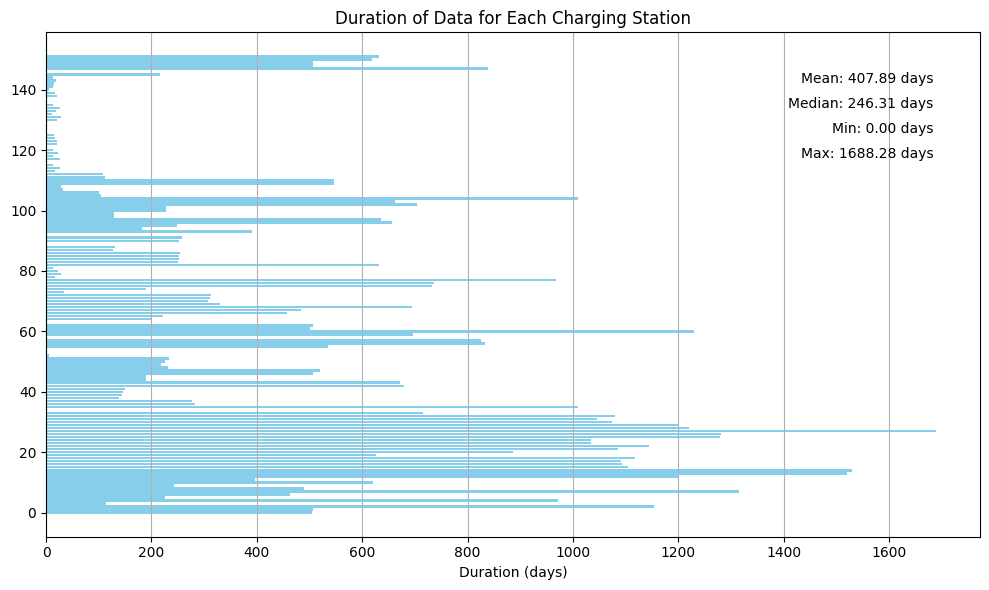

In [ ]:

df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'])

first_rows = df.groupby('Station Name').first()
last_rows = df.groupby('Station Name').last()

durations = []
station_names = []
for station, first_row in first_rows.iterrows():
    last_row = last_rows.loc[station]
    duration = (last_row['End_Time_EST'] - first_row['Start_Time_EST']).total_seconds() / 3600 / 24  # Convert to days
    durations.append(duration)
    station_names.append(station)

# ------------- statistics
mean_duration = pd.Series(durations).mean()
median_duration = pd.Series(durations).median()
min_duration = pd.Series(durations).min()
max_duration = pd.Series(durations).max()

plt.figure(figsize=(10, 6))
plt.barh(range(len(durations)), durations, color='skyblue')  # Use range(len(durations)) as y-values
plt.xlabel('Duration (days)')
plt.ylabel('')  # Empty string to remove y-axis label
plt.title('Duration of Data for Each Charging Station')
plt.grid(axis='x')

plt.text(0.95, 0.9, f'Mean: {mean_duration:.2f} days', horizontalalignment='right', transform=plt.gca().transAxes)
plt.text(0.95, 0.85, f'Median: {median_duration:.2f} days', horizontalalignment='right', transform=plt.gca().transAxes)
plt.text(0.95, 0.8, f'Min: {min_duration:.2f} days', horizontalalignment='right', transform=plt.gca().transAxes)
plt.text(0.95, 0.75, f'Max: {max_duration:.2f} days', horizontalalignment='right', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()



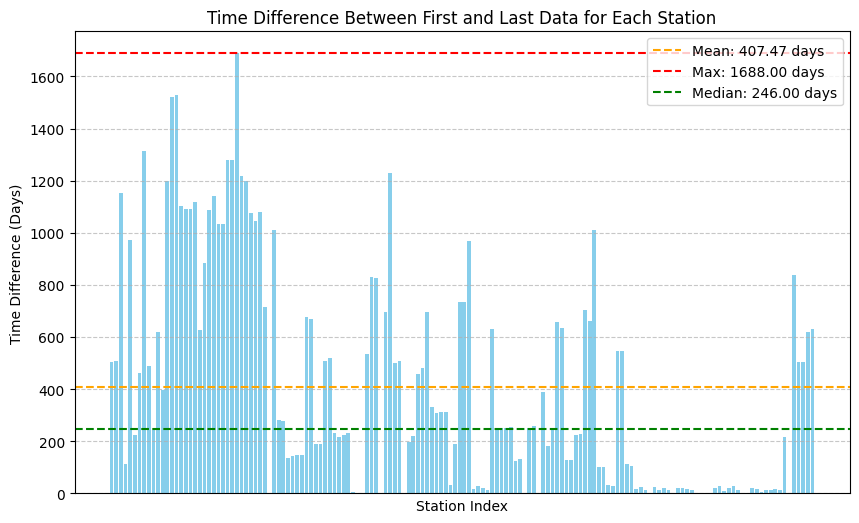

In [ ]:

df.sort_values(by=['Station Name', 'Start_Time_EST'], inplace=True)

df_grouped = df.groupby('Station Name').agg({
    'Start_Time_EST': 'first',
    'End_Time_EST': 'last'
}).reset_index()

df_grouped['Time_Difference_Days'] = (df_grouped['End_Time_EST'] - df_grouped['Start_Time_EST']).dt.days

plt.figure(figsize=(10, 6))
plt.bar(df_grouped.index, df_grouped['Time_Difference_Days'], color='skyblue')
plt.xlabel('Station Index')
plt.ylabel('Time Difference (Days)')
plt.title('Time Difference Between First and Last Data for Each Station')
plt.xticks([])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# ------------------------------------------------------statistics
mean_time_diff = df_grouped['Time_Difference_Days'].mean()
max_time_diff = df_grouped['Time_Difference_Days'].max()
median_time_diff = df_grouped['Time_Difference_Days'].median()

plt.axhline(y=mean_time_diff, color='orange', linestyle='--', label=f'Mean: {mean_time_diff:.2f} days')
plt.axhline(y=max_time_diff, color='red', linestyle='--', label=f'Max: {max_time_diff:.2f} days')
plt.axhline(y=median_time_diff, color='green', linestyle='--', label=f'Median: {median_time_diff:.2f} days')

plt.legend()
plt.show()


In [ ]:
date_columns = ['Start_Time_EST','End_charging_time', 'End_Time_EST' ]
for col in date_columns:
  df[col] = pd.to_datetime(df[col])

min_date= df[date_columns].min().min()
max_date = df[date_columns].max().max()

for col in date_columns:
  df[col +'_Norm']= (df[col]-min_date)/ (max_date-min_date)

# df['NORMA'] = (df.A- min_a) *(max_norm - min_norm) / (max_a-min_a) + min_norm ,    min_norm=-1  max_norm=1


In [ ]:
num_columns = ['Total Duration', 'Charging Time', 'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Fee']
for col in num_columns:
  min_val = df[col].min()
  max_val = df[col].max()
  df[col + '_Norm'] = (df[col] - min_val) / (max_val - min_val)


In [ ]:
df

,Station Name,MAC Address,Org Name,Address 1,City,State/Province,Zip/Postal Code,Driver Zip/Postal Code,User ID,Latitude,...,Ended By,Start_Time_EST_Norm,End_charging_time_Norm,End_Time_EST_Norm,Total Duration_Norm,Charging Time_Norm,Energy (kWh)_Norm,GHG Savings (kg)_Norm,Gasoline Savings (gallons)_Norm,Fee_Norm
0,7SPC / BR-JC LIBRARY_combined,0024:B100:0003:7806,Seven States Power Corp,201 N Roan St,Johnson City,Tennessee,37601,37687,4407231,36.319176,...,Plug Out at Vehicle,0.173102,0.173108,0.173108,0.012160,0.013136,0.012060,0.006788,0.012077,0.000000
1,7SPC / BR-JC LIBRARY_combined,0024:B100:0003:7806,Seven States Power Corp,201 N Roan St,Johnson City,Tennessee,37601,30703,2770771,36.319176,...,Customer,0.173115,0.173115,0.173115,0.000117,0.000000,0.000000,0.000000,0.000000,0.000000
2,7SPC / BR-JC LIBRARY_combined,0024:B100:0003:7806,Seven States Power Corp,201 N Roan St,Johnson City,Tennessee,37601,37687,4407231,36.319176,...,Plug Out at Vehicle,0.173129,0.173136,0.173136,0.014795,0.015991,0.014695,0.008263,0.014719,0.000000
3,7SPC / BR-JC LIBRARY_combined,0024:B100:0003:7806,Seven States Power Corp,201 N Roan St,Johnson City,Tennessee,37601,37687,4407231,36.319176,...,Plug Out at Vehicle,0.173137,0.173172,0.173208,0.136781,0.073204,0.063676,0.035819,0.063688,0.020844
4,7SPC / BR-JC LIBRARY_combined,0024:B100:0003:7806,Seven States Power Corp,201 N Roan St,Johnson City,Tennessee,37601,30703,2770771,36.319176,...,Customer,0.173143,0.173146,0.173146,0.006296,0.006574,0.005938,0.003338,0.005944,0.001459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38619,WRECC / STATION 2,0024:B100:0008:00F2,Warren RECC,675 Western Kentucky Pkwy,Beaver Dam,Kentucky,42320,37069,36139071,37.377178,...,Plug Out at Station,0.997367,0.997373,0.997373,0.012720,0.013516,0.133320,0.134995,0.133321,0.075143
38620,WRECC / STATION 2,0024:B100:0008:00F2,Warren RECC,675 Western Kentucky Pkwy,Beaver Dam,Kentucky,42320,37069,36139071,37.377178,...,ProximityLost,0.997376,0.997382,0.997382,0.011997,0.013021,0.120946,0.122459,0.120961,0.068161
38621,WRECC / STATION 2,0024:B100:0008:00F2,Warren RECC,675 Western Kentucky Pkwy,Beaver Dam,Kentucky,42320,40204,34152541,37.377178,...,Plug Out at Station,0.998264,0.998271,0.998271,0.014061,0.015255,0.148429,0.150292,0.148417,0.083585
38622,WRECC / STATION 2,0024:B100:0008:00F2,Warren RECC,675 Western Kentucky Pkwy,Beaver Dam,Kentucky,42320,NaN,452481V,37.377178,...,Plug Out at Station,0.998875,0.998899,0.998899,0.046414,0.050067,0.379220,0.383972,0.379205,0.213653


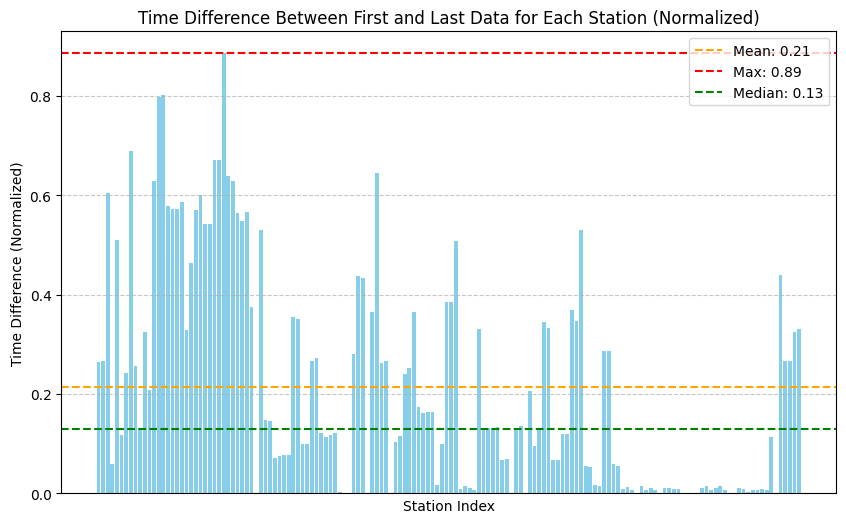

In [ ]:
df.sort_values(by=['Station Name', 'Start_Time_EST_Norm'], inplace=True)

df_grouped = df.groupby('Station Name').agg({
    'Start_Time_EST_Norm': 'first',
    'End_Time_EST_Norm': 'last'
}).reset_index()

df_grouped['Time_Difference_Norm'] = df_grouped['End_Time_EST_Norm'] - df_grouped['Start_Time_EST_Norm']

plt.figure(figsize=(10, 6))
plt.bar(df_grouped.index, df_grouped['Time_Difference_Norm'], color='skyblue')
plt.xlabel('Station Index')
plt.ylabel('Time Difference (Normalized)')
plt.title('Time Difference Between First and Last Data for Each Station (Normalized)')
plt.xticks([])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# ------------------------------------------------------statistics
mean_time_diff = df_grouped['Time_Difference_Norm'].mean()
max_time_diff = df_grouped['Time_Difference_Norm'].max()
median_time_diff = df_grouped['Time_Difference_Norm'].median()

plt.axhline(y=mean_time_diff, color='orange', linestyle='--', label=f'Mean: {mean_time_diff:.2f}')
plt.axhline(y=max_time_diff, color='red', linestyle='--', label=f'Max: {max_time_diff:.2f}')
plt.axhline(y=median_time_diff, color='green', linestyle='--', label=f'Median: {median_time_diff:.2f}')

plt.legend()
plt.show()
